# Sales Time Series Forecasting

Jungseo Lee

In [1]:
# import needed packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
import itertools
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from math import sqrt
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
import itertools
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from itertools import product
from IPython import display

### Prject goal
The file "Time Series Data.xlsx" contains sales data for one of the products from the consumer goods company, spanning four years from June 2018 to June 2022. Utilize this dataset, "Time Series Data.xlsx," to develop a forecast model that forecasts the sales till Dec 2023 by month.

In [2]:
# Data loading
df = pd.read_excel('Time Series Data.xlsx', header=0)

In [3]:
df.head()

,Time,Sales
0,2018-06-01,21577449.0
1,2018-07-01,23278971.0
2,2018-08-01,22769379.0
3,2018-09-01,21103080.0
4,2018-10-01,21272577.0


In [4]:
df.iloc[8:13]

,Time,Sales
8,2019-02-01,1.789357e+07
9,2019-03-03,1.898763e+07
10,2019-04-02,1.863687e+07
11,2019-05-02,2.042656e+07
12,2019-06-01,2.178326e+07


In [5]:
df.shape

(49, 2)

* Situation:
Certain data points were not gathered on the first day of each month.

* Assumption:
The data was acquired on the first business day of each month, the aggregate sales for the recorded moment are regarded as the total sales for the preceding month.  


I've identified that some data points were not collected on the first day of each month. As a result, I assumed that the data was collected on the first business day of each month, and the total sales for that recorded moment are considered as the total sales for the preceding month.

In [6]:
# Replacing the index with the datetime format of 'Time'

# Remove date info to ignore the different record date
df.Time = pd.to_datetime(df.Time).dt.strftime('%Y-%m')
df.Time = pd.to_datetime(df.Time).dt.strftime('%Y-%m-%d')
df.Time = pd.to_datetime(df.Time)
df.set_index(df.Time, inplace=True)
df.drop(columns='Time', inplace=True)
df.head()

,Sales
Time,
2018-06-01,21577449.0
2018-07-01,23278971.0
2018-08-01,22769379.0
2018-09-01,21103080.0
2018-10-01,21272577.0


In [7]:
# Change sales values in millions
df['Sales(M)'] = df['Sales']* 1e-6
df.head()

,Sales,Sales(M)
Time,,
2018-06-01,21577449.0,21.577449
2018-07-01,23278971.0,23.278971
2018-08-01,22769379.0,22.769379
2018-09-01,21103080.0,21.103080
2018-10-01,21272577.0,21.272577


In [8]:
# Drop sales in original unit
df.drop(columns='Sales', inplace=True)
df.head()

,Sales(M)
Time,
2018-06-01,21.577449
2018-07-01,23.278971
2018-08-01,22.769379
2018-09-01,21.103080
2018-10-01,21.272577


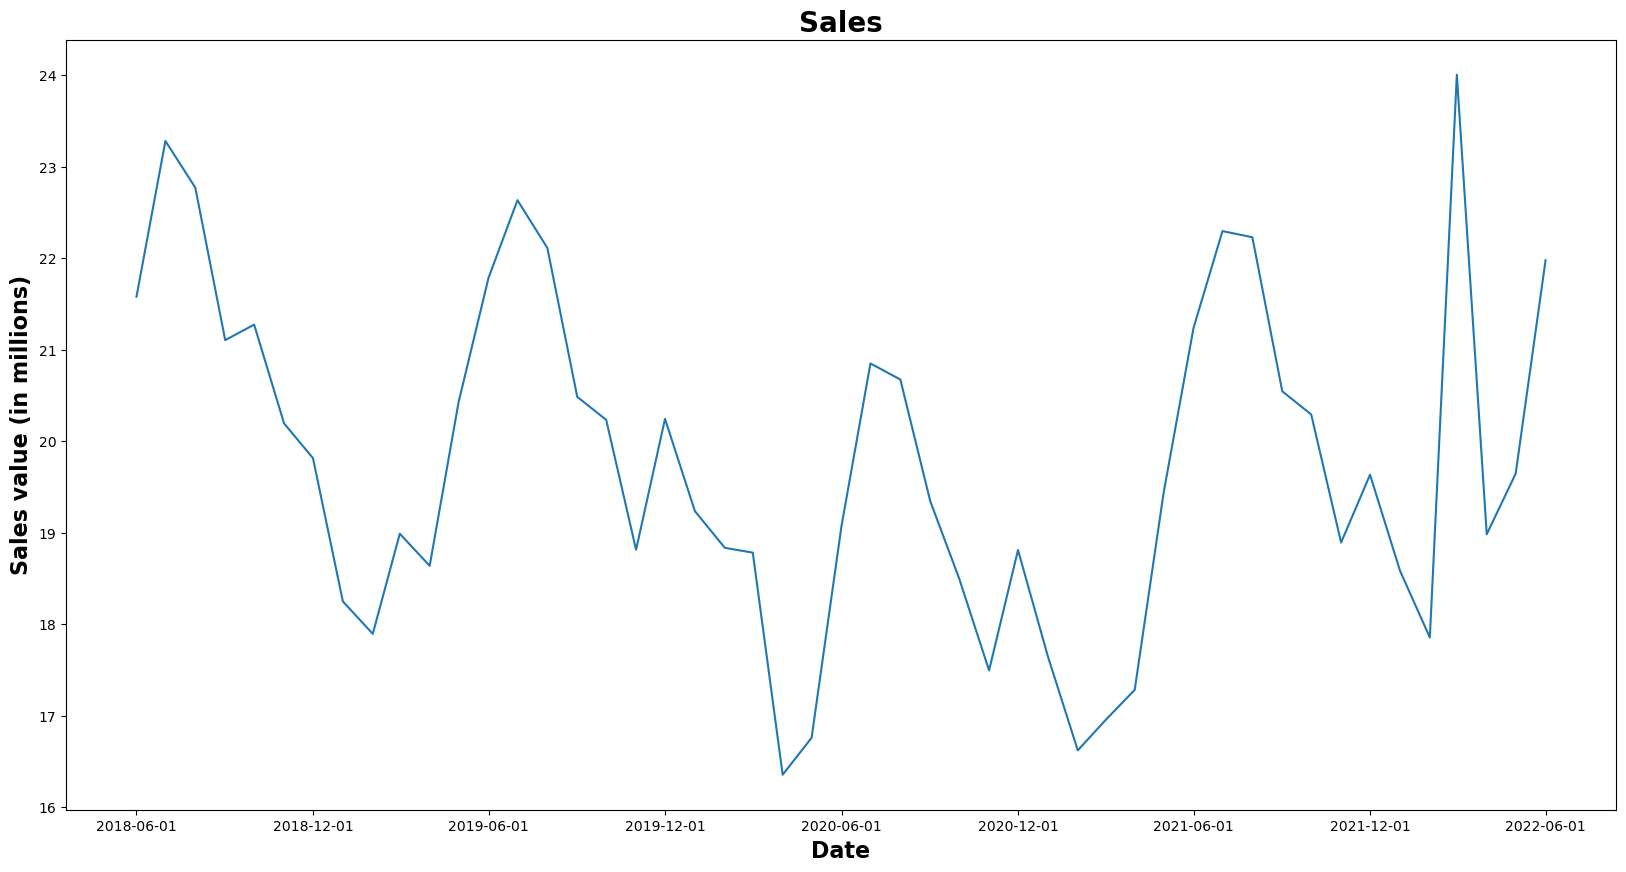

In [9]:
# Visualize the sales values by time

plt.rcParams["figure.figsize"] = (20,10)
plt.plot(df)
plt.title("Sales",fontsize=20, fontweight='bold')
plt.xticks(df.index[::6])
plt.ylabel("Sales value (in millions)", fontsize=16,fontweight='bold')
plt.xlabel("Date",fontsize=16, fontweight='bold')
plt.show()

In order to construct an appropriate time series model, it is crucial to ascertain whether the dataset displays any of the following features:

1. Trend: A trend signifies a consistent, long-term increase or decrease in the data values over time.
1. Seasonality: Seasonality alludes to periodic fluctuations or patterns that repeat themselves at regular intervals within the data.
1. Stationarity: Stationarity denotes that the statistical characteristics of the data remain constant over time, including its mean and variance.

### EDA

#### Trend: Moving average

To identify trends, we can get average over rolling n-windows. From the plot above, there might be some yearly seasonality for 12 months. There, I calculated the average of the sales values over the previous 12 months.

In [10]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):  
    
    # 95% of the area of a normal distribution is within 1.96 standard deviations of the mean
    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    plt.xticks(df.index[::6])
    plt.title("Sales",fontsize=16, fontweight='bold')
    plt.ylabel("Sales value(millions)", fontsize=12,fontweight='bold')
    plt.xlabel("Date",fontsize=12, fontweight='bold')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)
    
# code: https://towardsdatascience.com/the-complete-guide-to-time-series-analysis-and-forecasting-70d476bfe775

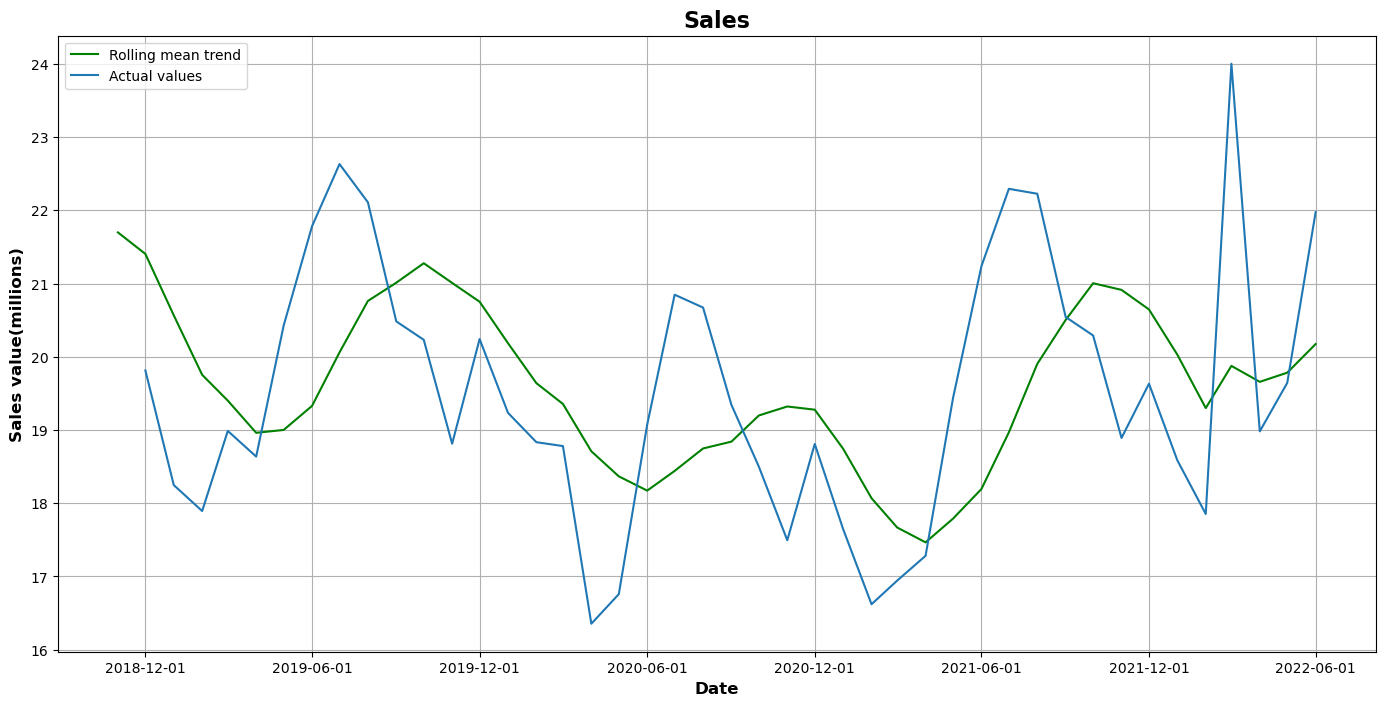

In [11]:
# smoothed with 6 month window
plot_moving_average(df,6)

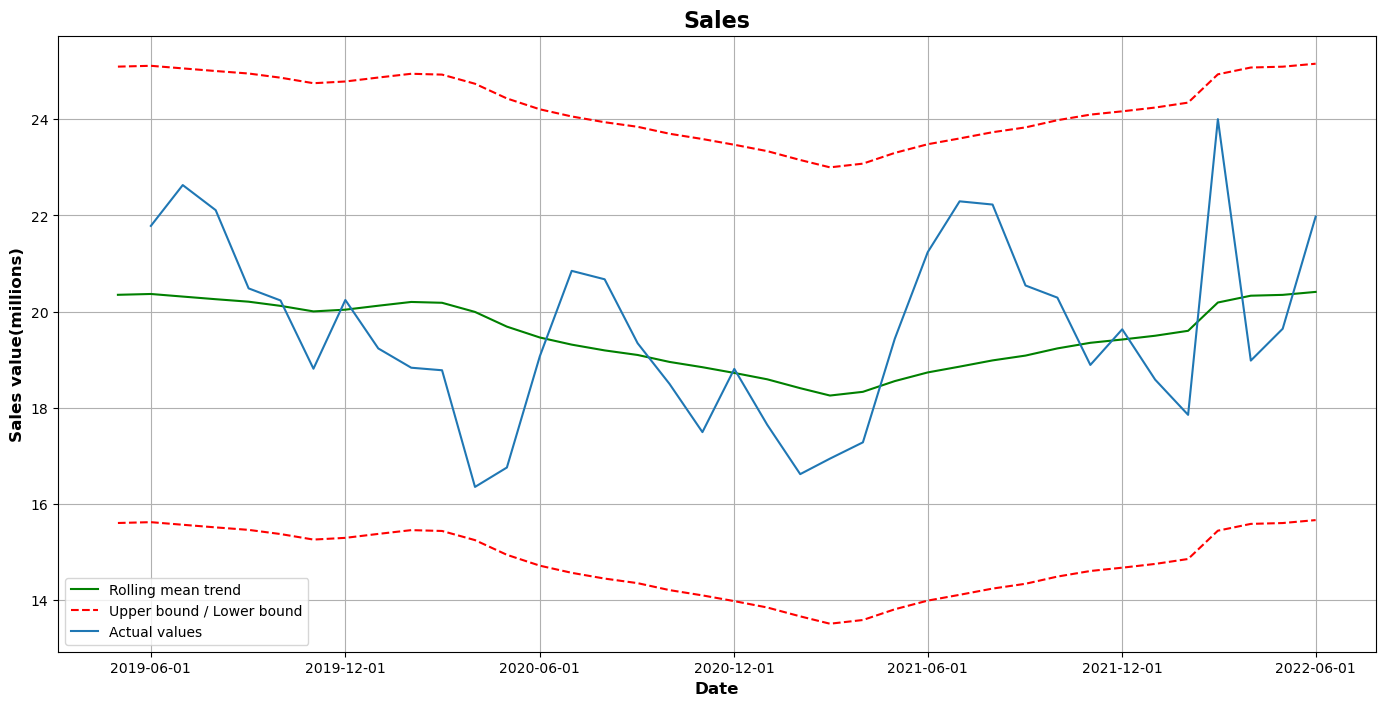

In [12]:
# smoothed with 1 year window
plot_moving_average(df,12, plot_intervals=True)

#### Seasonality: Seasonal_decompose

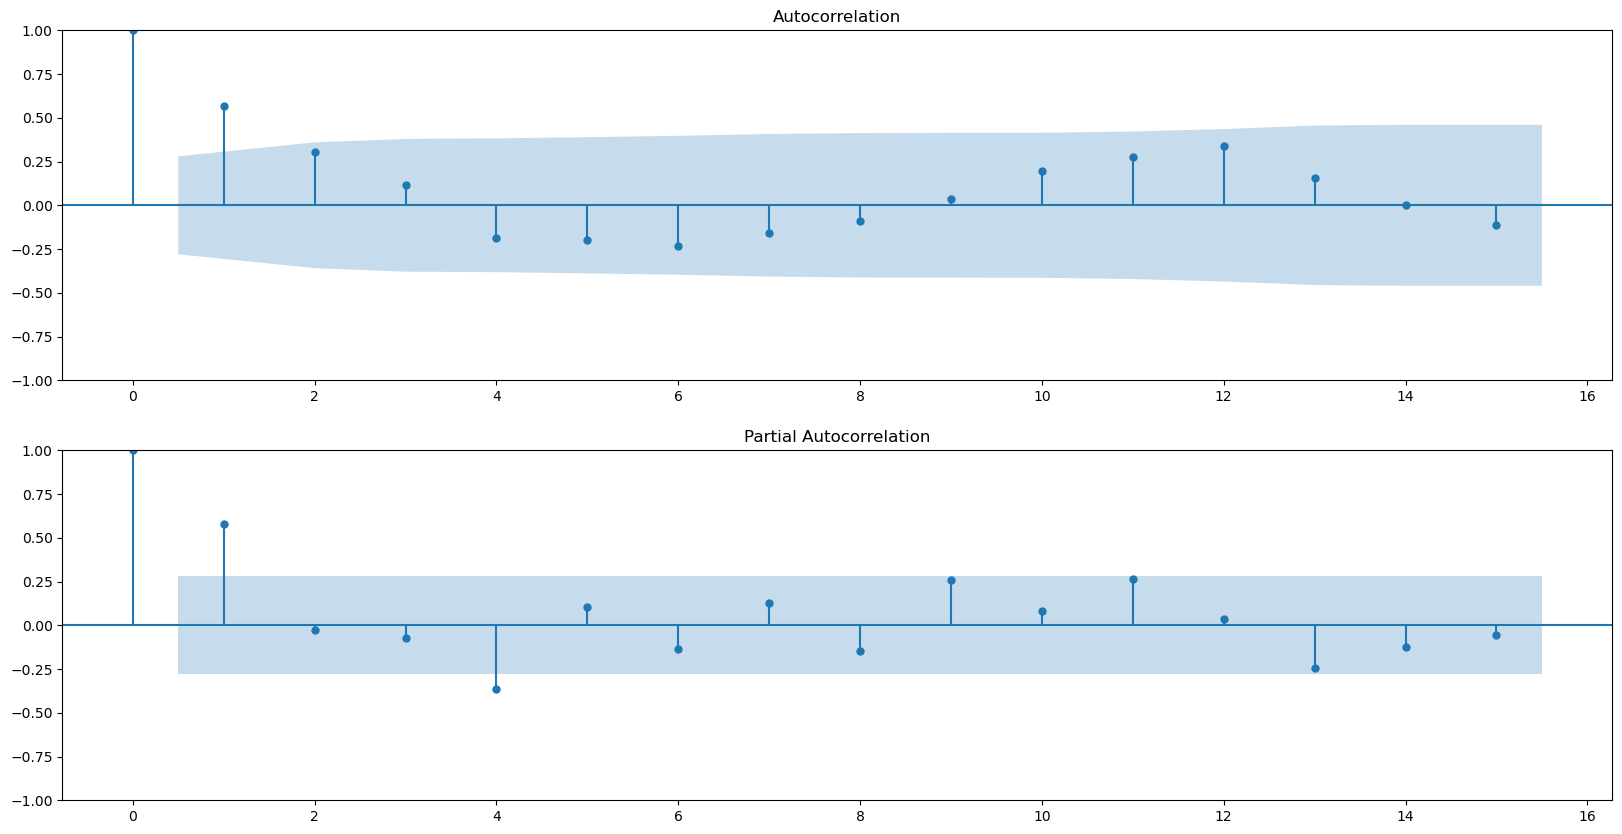

In [13]:
fig, ax = plt.subplots(2,1)
fig = plot_acf(df, lags=15, ax=ax[0]);
fig = plot_pacf(df, lags=15, ax=ax[1]);
plt.show()

There are significant spikes in the ACF plot at lag 1 and lag 12. In the PACF plot, there are significant spikes at lag 1 and 4 and lags are slower to decay. From here, we can get some idea about the parameters to get the best perform model.

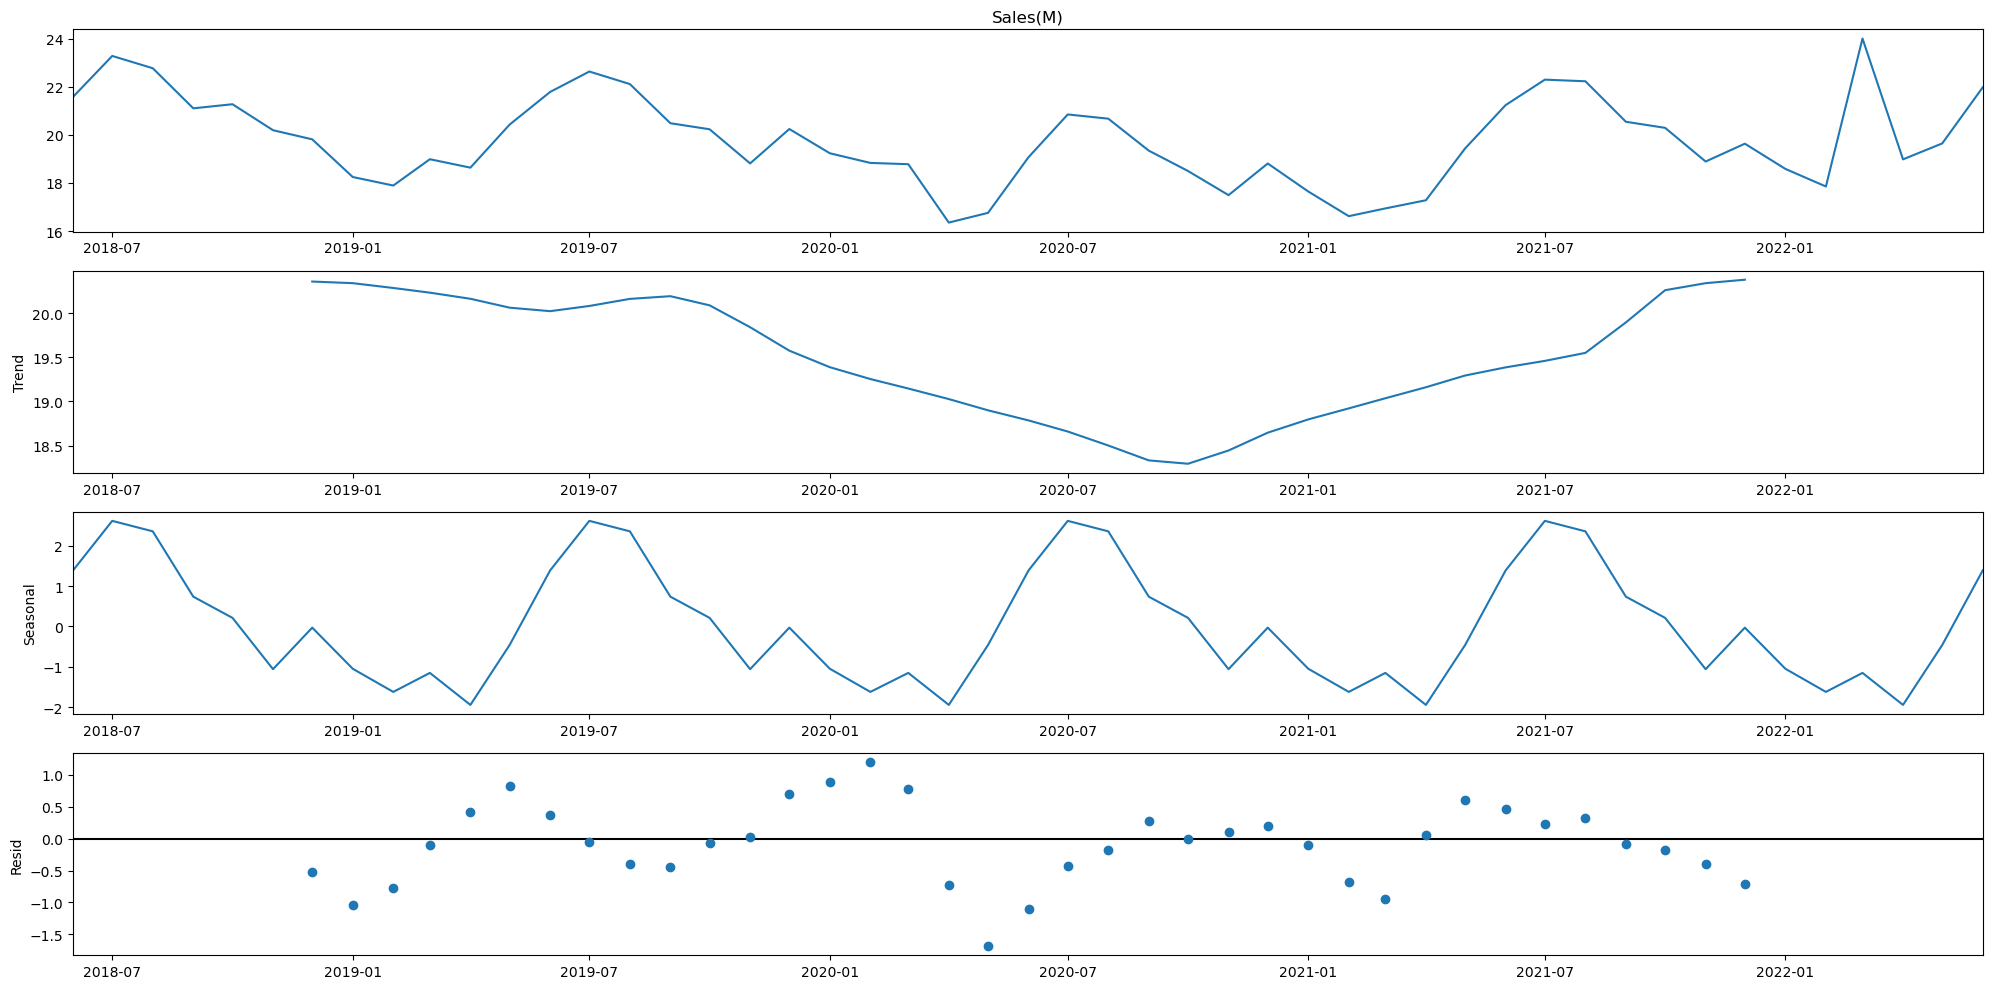

In [14]:
decomposition_plot = seasonal_decompose(df['Sales(M)'],model='additive')
decomposition_plot.plot()
plt.show()

After analyzing the time series data through autocorrelation and seasonal decomposition techniques, it became apparent that the data exhibits clear trends and seasonality, and displays a significant correlation with a 12th lag.

#### Stationary: Dickey-Fuller Test

To model the time series, it's important to have stationary time series, whereby its statistical properties such as mean and variance remain constant over time. To assess the stationarity of the data, we can conduct a statistical test such as the Dickey-Fuller test.

H0 of the Dickey Fuller test is that the data is non-stationary.

In [15]:
# Function to test the stationarity
def test_stationarity(timeseries):
    
    # Rolling Statistics Test
    # Determing rolling statistics
    roll_mean = timeseries.rolling(window=12).mean()
    roll_std = timeseries.rolling(window=12).std()
    # Plotting rolling statistics:
    orig=plt.plot(timeseries, color='black',label='Original')
    mean= plt.plot(roll_mean , color='red',label='Rolling Mean')
    std=plt.plot(roll_std,color='blue',label = 'Rolling Standard Deviation')
    plt.xticks(timeseries.index[::6])
    plt.legend(loc='best')
    plt.title("Rolling mean and standard deviation")
    plt.show(block=False)
    
    # Performing Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
           print(key, value)
            
# code: https://medium.com/analytics-vidhya/predicting-sales-time-series-analysis-forecasting-with-python-b81d3e8ff03f

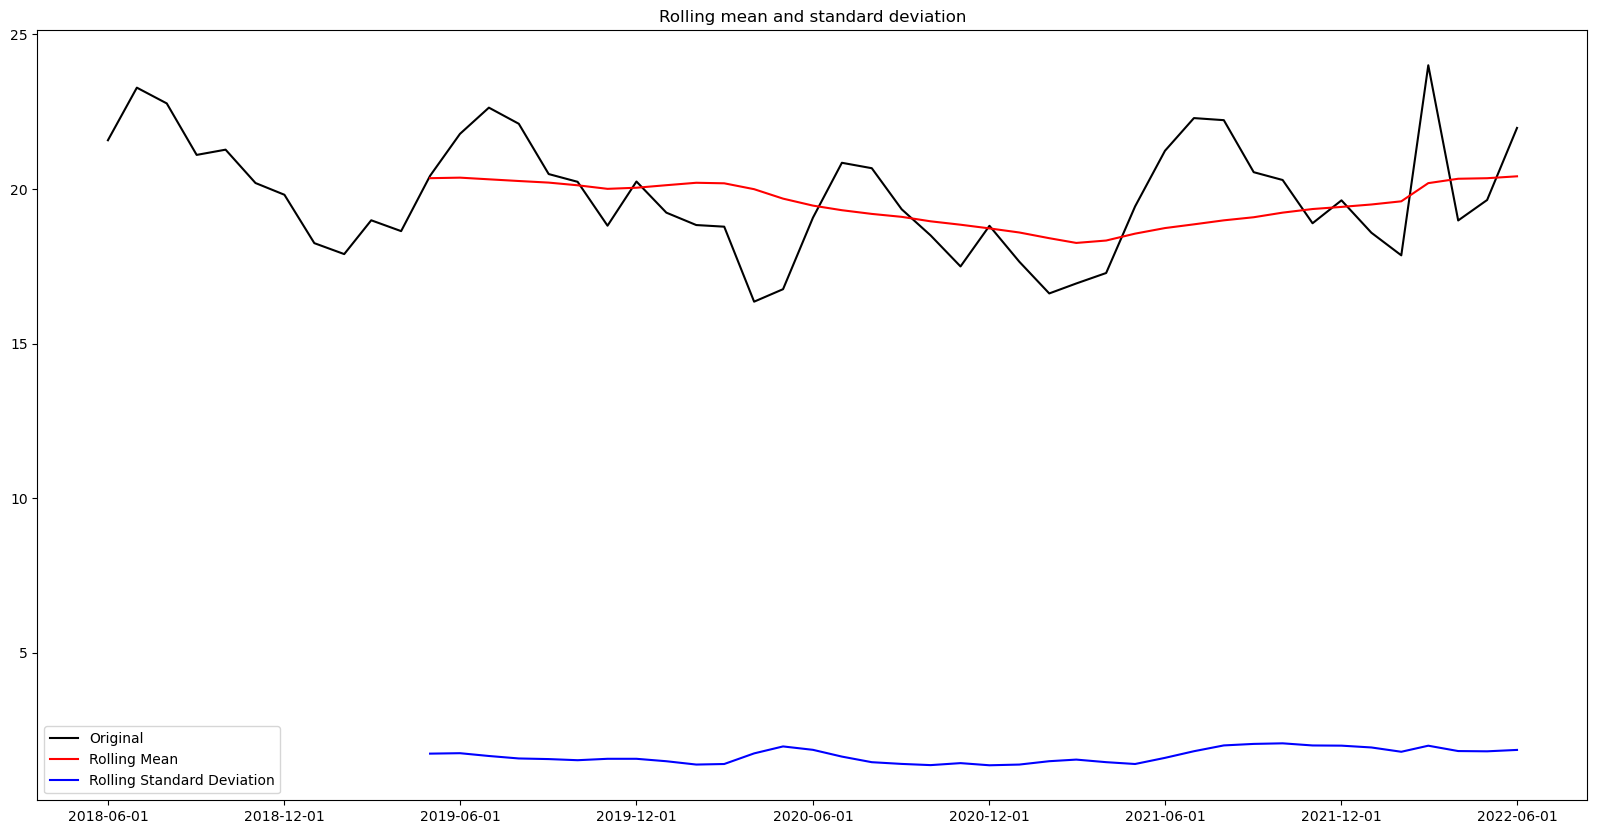

Results of Dickey-Fuller Test:
ADF Statistic: -3.435508
p-value: 0.009806
Critical Values:
1% -3.5745892596209488
5% -2.9239543084490744
10% -2.6000391840277777


In [16]:
# Testing stationarity of df
test_stationarity(df)

As the p-value is less than the significance level of 0.05, we can reject the null hypothesis that the data is non-stationary. We can conclude that the data is stationary and satisfies the requirement for constructing a time series model without any further transformation.

### Modeling

#### ARIMA(Autoregressive Integrated Moving Average)

#### Model selection

In [17]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]  # last value of seasonal_pdq: length of season

print('Examples of parameter combinations for Seasonal ARIMA: ')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA: 
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [18]:
# Find out the optimal set of parameters for the best performance for the model

# set initial lowest AIC
lowest_aic = 100

for param in pdq:
    warnings.filterwarnings('ignore')
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit(disp=0)
            
            if results.aic < lowest_aic:
                
                # replace the lowest_aic with the new one
                lowest_aic = results.aic
                print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:99.42826409035928
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:91.08189777999455
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:90.77920449722475
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:89.16217729217308
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:84.53342189051568
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:84.18690458773955


The above output suggests that ARIMA(0, 1, 1)x(1, 1, 1, 12)12 yields the lowest AIC value of 84.19. We should consider this option to be the optimal params.

#### Fitting the model

In [19]:
mod = sm.tsa.statespace.SARIMAX(df,
                                order=(0, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_invertibility=False)
results = mod.fit(disp=0)
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4927      0.243     -2.024      0.043      -0.970      -0.016
ar.S.L12      -0.4680      1.202     -0.389      0.697      -2.824       1.888
ma.S.L12      -0.3803      2.520     -0.151      0.880      -5.320       4.560
sigma2         1.4116      0.942      1.498      0.134      -0.436       3.259


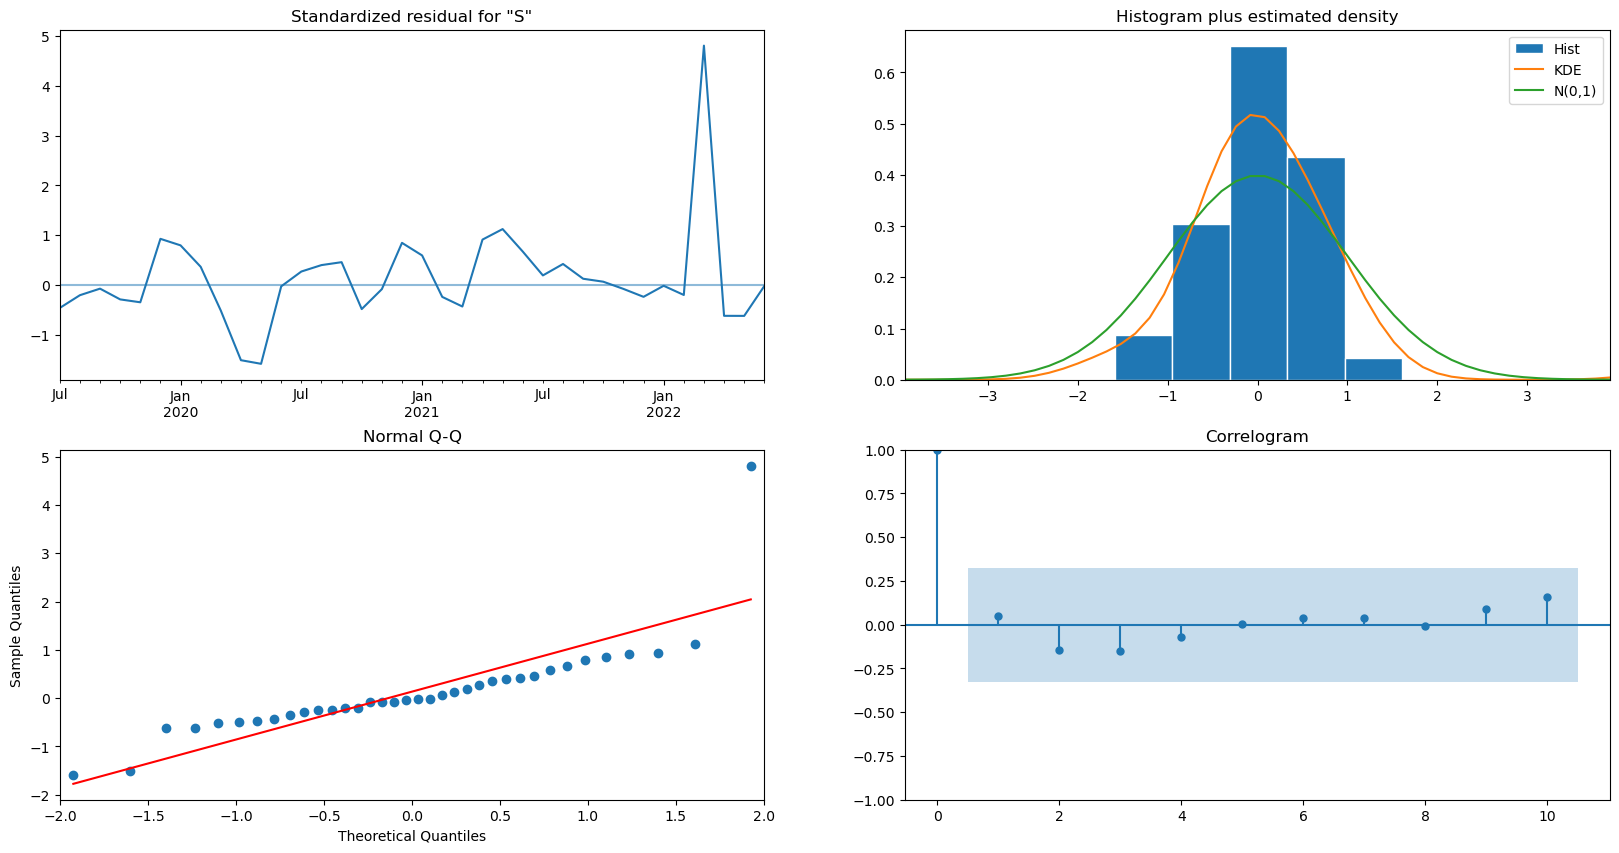

In [20]:
# model diagnostic to see if the residuals are normally distributed
results.plot_diagnostics()
plt.show()

The Normal Q-Q plot shows that the ordered distribution of residuals follows the distribution similar to normal distribution. Thus, our model seems to be pretty good.

#### Validation

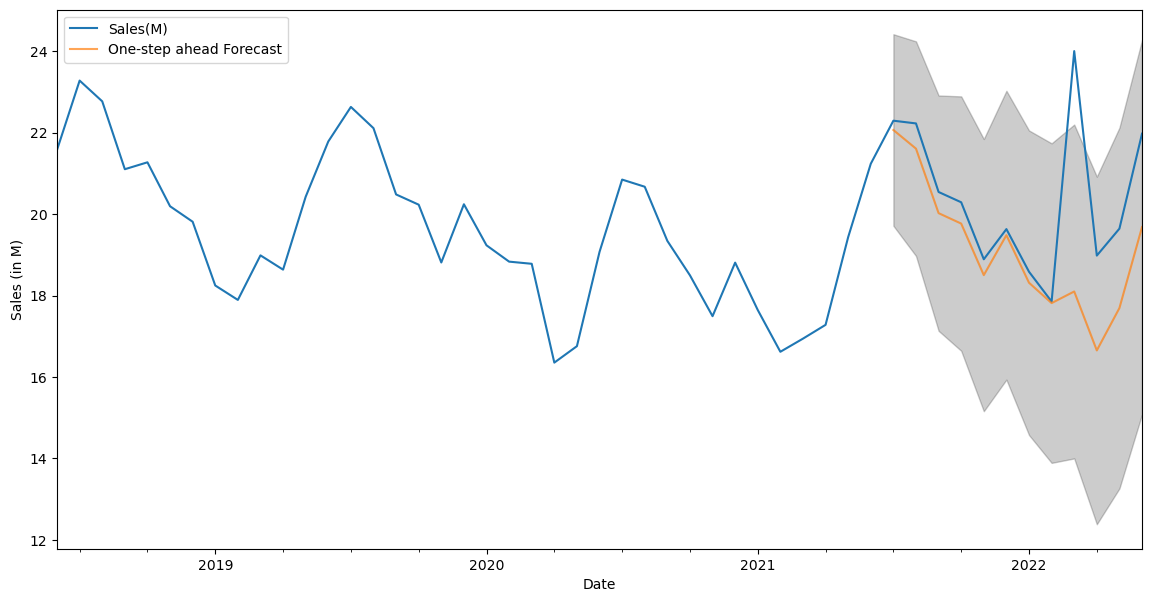

In [21]:
pred = results.get_prediction(start=pd.to_datetime('2021-07-01'), end= pd.to_datetime('2022-06-01'),dynamic=True)
pred_ci = pred.conf_int()
ax = df['2018-06-01':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Sales (in M)')
plt.legend()
plt.show()

In [22]:
y_forecasted = pred.predicted_mean
y_truth = df['2021-07-01':]

# calculating the error
rms_arima = sqrt(mean_squared_error(y_truth,y_forecasted))
print("Root Mean Squared Error: ", rms_arima)

Root Mean Squared Error:  2.052557919138913


In [23]:
print('sales min in millions: ', df.min(), 'sales max in millions: ', df.max())

sales min in millions:  Sales(M)    16.354269
dtype: float64 sales max in millions:  Sales(M)    24.003189
dtype: float64


Based on our analysis, the root mean squared error (RMSE) is approximately 2. This suggests that our model is capable of forecasting monthly sales within a margin of 2 million from the actual sales figures in the validation set. Considering the fact that our monthly sales volume falls within the range of 16.4 million to 24 million units, we can conclude that the model is performing well.

#### Producing and visualizing future forecasts

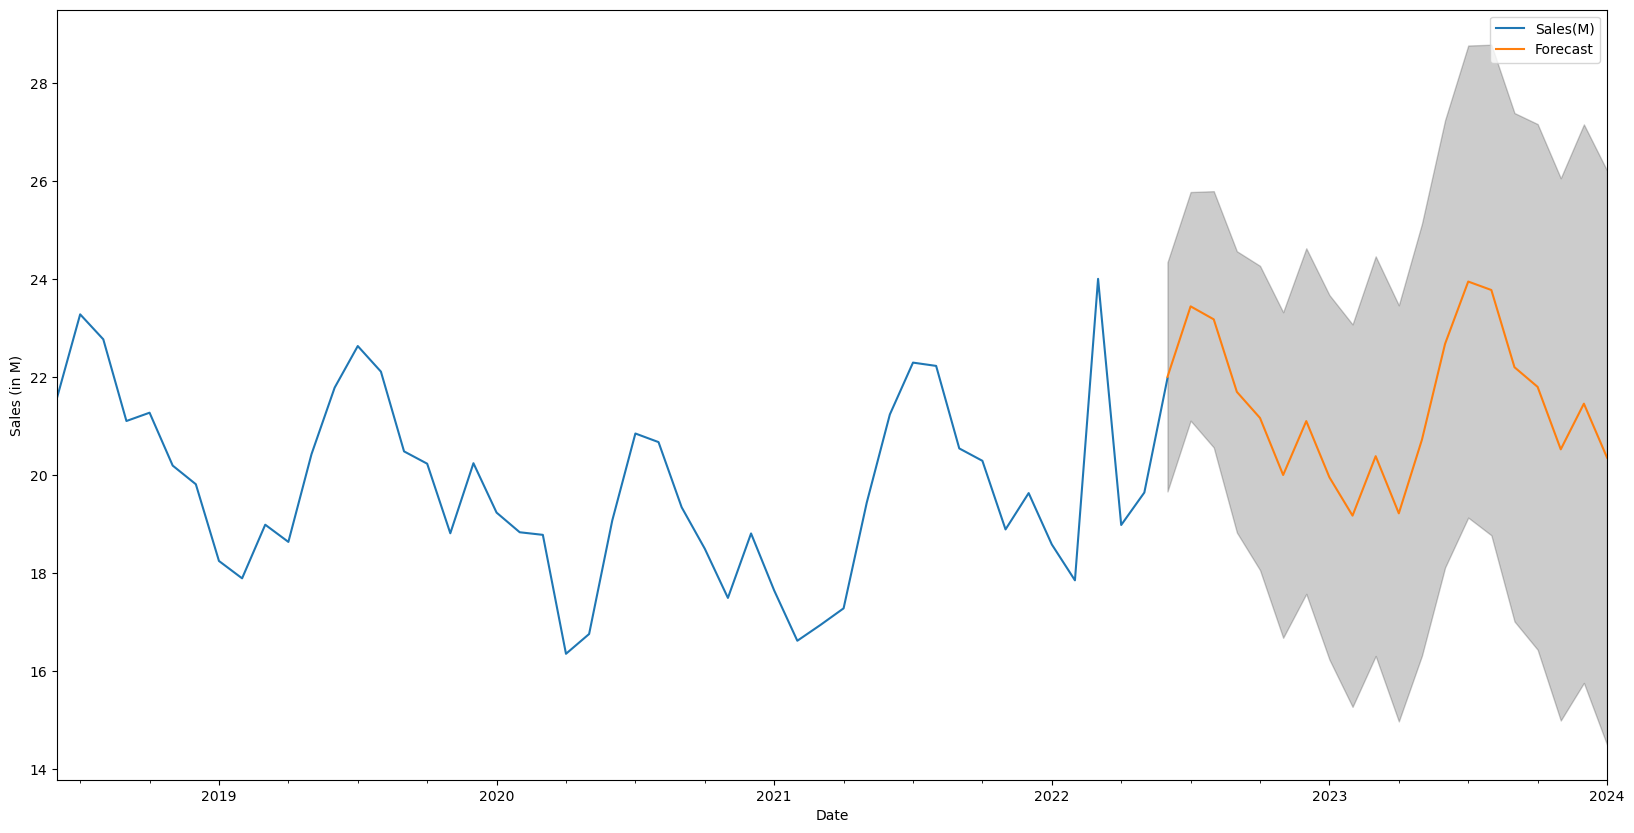

In [24]:
pred_uc = results.get_prediction(start=pd.to_datetime('2022-06-01'), end= pd.to_datetime('2024-01-01'), dynamic=False)
pred_ci = pred_uc.conf_int()

ax = df['2018-06-01':].plot(label='observed')

pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
#pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Sales (in M)')
plt.legend()
plt.show()

In [25]:
# future date prediction
future = pred_uc.predicted_mean.to_frame()

In [26]:
future.head()

,predicted_mean
2022-06-01,22.003274
2022-07-01,23.442022
2022-08-01,23.177034
2022-09-01,21.696923
2022-10-01,21.165322


In [27]:
# drop the first row and change column name to combine with the initial dataframe
future.drop(axis=0, index='2022-06-01', inplace=True)
future.head()
future_sales = future
future_sales = future_sales.rename({'predicted_mean':'Sales(M)'},axis=1)

In [28]:
# combine with the original df
sales = pd.concat([df, future_sales], axis=0)

In [29]:
sales.to_csv("sales_prediction.csv")
sales

,Sales(M)
2018-06-01,21.577449
2018-07-01,23.278971
2018-08-01,22.769379
2018-09-01,21.103080
2018-10-01,21.272577
...,...
2023-09-01,22.200064
2023-10-01,21.798945
2023-11-01,20.524830
2023-12-01,21.456913


Show the Total Sales by year from 2019 to 2023 and calculate the percent change versus previous year.

Given the aforementioned assumption that the recording date represents the total sales amount for the preceding month, I aim to transform the existing dataframe such that it reflects the sales data for the final day of each month.

In [30]:
# create a new column with the last date that sales was counted
sales['date_before'] = sales.index - pd.DateOffset(days=1)

In [31]:
sales

,Sales(M),date_before
2018-06-01,21.577449,2018-05-31
2018-07-01,23.278971,2018-06-30
2018-08-01,22.769379,2018-07-31
2018-09-01,21.103080,2018-08-31
2018-10-01,21.272577,2018-09-30
...,...,...
2023-09-01,22.200064,2023-08-31
2023-10-01,21.798945,2023-09-30
2023-11-01,20.524830,2023-10-31
2023-12-01,21.456913,2023-11-30


In [32]:
# get sum by year
sales_by_last_date = sales.set_index(sales.date_before)
sales_by_last_date.index.name = 'Time'
sales_by_last_date.drop('date_before', axis=1, inplace=True)
yearly_sum = sales_by_last_date.resample('Y').sum()

In [33]:
yearly_sum

,Sales(M)
Time,
2018-12-31,168.256279
2019-12-31,241.476509
2020-12-31,223.111500
2021-12-31,233.984255
2022-12-31,252.997861
2023-12-31,256.238673


In [34]:
# get percentage change versus previous year
yearly_sum['Change_vs_previous_year(%)'] = yearly_sum['Sales(M)'].pct_change(periods=1)
yearly_sum.to_csv("sales_change.csv")
yearly_sum

,Sales(M),Change_vs_previous_year(%)
Time,,
2018-12-31,168.256279,NaN
2019-12-31,241.476509,0.435171
2020-12-31,223.111500,-0.076053
2021-12-31,233.984255,0.048732
2022-12-31,252.997861,0.081260
2023-12-31,256.238673,0.012810


Note that we only have 6 months data for 2018.

### Model evaluation

To evaluate the forecasting model, I used root mean sqauared error as a error metric in this analysis.

In [35]:
print("Root Mean Squared Error: ", rms_arima)

Root Mean Squared Error:  2.052557919138913


There exist three scale-dependent error metrics, which are simple to compute and interpret since they are expressed in the original unit of the data. The unique characteristics associated with each of these metrics are outlined below:

* Mean Absolute Error (MAE): This metric is straightforward to calculate and interpret, rendering it suitable for assessing accuracy on a single series. However, it is not suitable for comparing different series that use distinct units of measurement.
* Mean Squared Error (MSE): This metric heavily weights large errors, thereby penalizing significant deviations. Consequently, it is suitable when outliers require special attention.
* Root Mean Square Error (RMSE): By utilizing the same units as the original data and penalizing large errors, this metric provides an effective measure of accuracy.

#### How to reduce RMSE in time series?

1. Increasing the amount of data and data points is a common technique for improving the accuracy of a model, as it can help to capture more information and reduce noise.

1. Identifying and accounting for data anomalies can help to improve model accuracy by removing or adjusting anomalous data points. This can be done by using external data to account for influencing events or measurements, or by identifying patterns that may explain the anomalous data. Within the present dataset, a sudden surge in sales was observed during the early months of 2022. In light of this observation, it would be prudent to consider utilizing external data sources, such as social media sentiment analysis, to ascertain customer satisfaction and interest in the company's products, in order to determine whether to retain or exclude the anomalous data. Economic indicators, including consumer spending, inflation, and unemployment rates, may also serve as valuable external data sources, as they can influence consumer behavior and purchasing decisions.
